### Predicting Air Quality for Informed Decision Making

- https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge
- https://airqo.net/

Forecast air quality (as measured by PM2.5 µ/m3) for each hour of the coming 25 hours across five locations in Kampala Uganda. <br> Forecasts will be based on the past 5 days of hourly air quality measurements at each site.

RULES:
- cannot use meta-data provided
- eval metric: Root Mean Squared Error

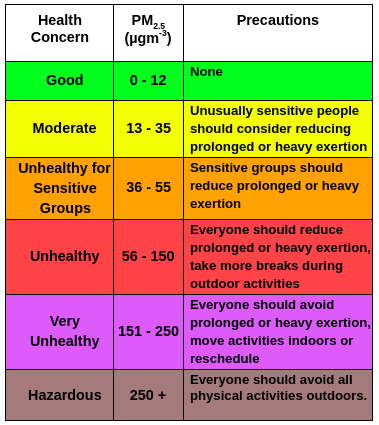

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns
from tqdm import tqdm
import math
import gc

In [3]:
train=pd.read_csv("Train.csv")
test=pd.read_csv("Test.csv")

In [4]:
train.head() # 15000 sets

ID location                                               temp  \
0     ID_train_0        C  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1     ID_train_1        D  22.53333333,21.71666667,20.83333333,20.9833333...   
2    ID_train_10        A  28.975,27.95,29.6,26.425,22.09166667,21.775,22...   
3   ID_train_100        A  22.96666667,24.26666667,25.275,25.625,25.86666...   
4  ID_train_1000        A  21.875,21.575,21.525,21.43333333,20.50833333,1...   

                                              precip  \
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1  0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...   
2  0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...   
3  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...   
4  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....   

                                        rel_humidity  \
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1  0.744583333,0.808083333,0.911166667,0.91633333...   
2  0.573333333,0.597166667,0.5668333329999999,0.6...   
3  0.8430833329999999,0.79025,0.7375,0.728,0.7049...   
4  0.8564166670000001,0.874916667,0.879833333,0.8...   

                                            wind_dir  \
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1  281.6643101,89.15629262,81.96853891,291.018632...   
2  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
3  300.0850574,293.6769595,294.5174647,301.921416...   
4  21.83997432,17.05405341,89.26406044,123.585424...   

                                            wind_spd  \
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1  2.3775,1.126666667,0.700833333,0.3416666670000...   
2  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
3  1.446666667,1.1925,1.324166667,1.5441666669999...   
4  0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...   

                                         atmos_press      target  
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   45.126304  
1  90.32,90.3775,90.44083333,90.4725,90.45416667,...   79.131702  
2  88.55166667,88.46416667,88.31916667,88.24,88.2...   32.661304  
3  88.615,88.53083333,88.4,88.27166667,88.2075,88...   53.850238  
4  88.55666667,88.64083333,88.65833333,88.6475,88...  177.418750

From https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge/data:
        - there are 5 sensors
        - no date/time is provided

In [5]:
test.head() # 5000 sets

ID location                                               temp  \
0     ID_test_0        C  23.96666667,22.88333333,22.28333333,21.4833333...   
1     ID_test_1        C  18.99166667,19.70833333,20.95833333,22.7833333...   
2    ID_test_10        D  25.11666667,25.08333333,24.40833333,23.575,22....   
3   ID_test_100        C  18.71666667,20.60833333,22.28333333,23.9833333...   
4  ID_test_1000        D  17.63333333,18.05833333,19.625,21.28333333,23....   

                                              precip  \
0  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....   
1  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....   
2  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....   
3  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.604,0.0,0.0,...   
4  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....   

                                        rel_humidity  \
0  0.6898333329999999,0.722333333,0.7755833329999...   
1  0.99975,0.99725,0.956333333,0.851583333,0.7775...   
2  0.760166667,0.733583333,0.78475,0.825833333,0....   
3  0.951416667,0.92575,0.8603333329999999,0.77883...   
4  0.9,0.898333333,0.8725,0.831666667,0.820833332...   

                                            wind_dir  \
0  290.1352379,328.47011289999995,323.5730796,282...   
1  295.2350543,307.6569135,313.7360236,311.518385...   
2  77.06161145,95.48124997,61.44498258,89.4688360...   
3  310.7509058,316.186793,324.8167326,327.2174992...   
4  334.6054069,329.6848561000001,322.7668036,312....   

                                            wind_spd  \
0  0.6333333329999999,0.725,0.955,0.8725,0.6925,0...   
1  0.640833333,1.244166667,1.284166667,1.2875,1.3...   
2  2.0133333330000003,1.3025,0.783333333,0.530833...   
3  0.745,1.169166667,1.316666667,1.385,1.40083333...   
4  0.620833333,0.5,0.456666667,0.558333333,1.0158...   

                                         atmos_press  
0  87.64333333,87.67,87.70583333,87.75083333,87.7...  
1  87.8925,87.95666667,87.9925,87.9925,87.9808333...  
2  90.34,90.2975,90.305,90.35583333,90.4425,90.49...  
3  87.98833333,88.06333333,88.07833333,88.0366666...  
4  90.515,90.5575,90.62333333,90.6825,90.67916667...

## Pre-processing

In [6]:
# covert features from string to List of values 
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)
    
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature]=train[feature].apply(lambda x: [replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test[feature]=test[feature].apply(lambda x: [replace_nan(X) for X in x.replace("nan"," ").split(",")])    

### Features engineering part

In [7]:
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  

def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]

In [8]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)
data.columns.tolist()

['ID',
 'location',
 'temp',
 'precip',
 'rel_humidity',
 'wind_dir',
 'wind_spd',
 'atmos_press',
 'target']

In [9]:
data.shape

(20574, 9)

In [10]:
# remove nan values from feature space
# features = ['temp', 'precip', 'rel_humidity', 'wind_dir', 'wind_spd', 'atmos_press']

for col_name in tqdm(features):
    data[col_name]=data[col_name].apply(remove_nan_values)

100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


In [11]:
# get aggregate features
# max, min, mean, std, var, median, ptp

for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████| 6/6 [00:21<00:00,  3.59s/it]


In [12]:
for x in range(121):
    data["newtemp"+ str(x)] = data.temp.str[x]
    data["newprecip"+ str(x)] = data.precip.str[x]
    data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atmospherepressure"+ str(x)] = data.atmos_press.str[x]

In [13]:
data.head(1)

ID location                                               temp  \
0  ID_train_0        C  [26.90909091, 27.20833333, 26.18333333, 24.7, ...   

                                              precip  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        rel_humidity  \
0  [0.510818182, 0.535416667, 0.6145, 0.633, 0.68...   

                                            wind_dir  \
0  [272.9027516, 104.565241, 167.1772247, 165.332...   

                                            wind_spd  \
0  [0.800909091, 1.073333333, 1.5175, 1.4625, 0.5...   

                                         atmos_press     target   max_temp  \
0  [87.77727273, 87.6525, 87.61416667, 87.6375, 8...  45.126304  27.208333   

   ...  newrel_humidity119  newwind_dir119  windspeed119  \
0  ...                 NaN             NaN           NaN   

   atmospherepressure119  newtemp120  newprecip120  newrel_humidity120  \
0                    NaN         NaN           NaN                 NaN   

   newwind_dir120  windspeed120  atmospherepressure120  
0             NaN           NaN                    NaN  

[1 rows x 777 columns]

In [14]:
# drop original features 
data.drop(features,1,inplace=True)

data.head(1)

ID location     target   max_temp  min_temp  mean_temp  std_temp  \
0  ID_train_0        C  45.126304  27.208333    19.275  22.299527  2.594011   

   var_temp  median_temp  ptp_temp  ...  newrel_humidity119  newwind_dir119  \
0  6.728895    21.358333  7.933333  ...                 NaN             NaN   

   windspeed119  atmospherepressure119  newtemp120  newprecip120  \
0           NaN                    NaN         NaN           NaN   

   newrel_humidity120  newwind_dir120  windspeed120  atmospherepressure120  
0                 NaN             NaN           NaN                    NaN  

[1 rows x 771 columns]

In [15]:
train=data[data.target.notnull()].reset_index(drop=True)
test=data[data.target.isna()].reset_index(drop=True)

In [16]:
display(train.head(1))
print('\n')

display(test.head(1))

ID location     target   max_temp  min_temp  mean_temp  std_temp  \
0  ID_train_0        C  45.126304  27.208333    19.275  22.299527  2.594011   

   var_temp  median_temp  ptp_temp  ...  newrel_humidity119  newwind_dir119  \
0  6.728895    21.358333  7.933333  ...                 NaN             NaN   

   windspeed119  atmospherepressure119  newtemp120  newprecip120  \
0           NaN                    NaN         NaN           NaN   

   newrel_humidity120  newwind_dir120  windspeed120  atmospherepressure120  
0                 NaN             NaN           NaN                    NaN  

[1 rows x 771 columns]

ID location  target   max_temp  min_temp  mean_temp  std_temp  \
0  ID_test_0        C     NaN  26.858333     17.05  21.389532  2.731833   

   var_temp  median_temp  ptp_temp  ...  newrel_humidity119  newwind_dir119  \
0  7.462909    20.908333  9.808333  ...             0.72525       167.41234   

   windspeed119  atmospherepressure119  newtemp120  newprecip120  \
0      1.289167                  87.58   22.766667           0.0   

   newrel_humidity120  newwind_dir120  windspeed120  atmospherepressure120  
0                 NaN      163.667416      0.774167              87.625833  

[1 rows x 771 columns]

In [17]:
train.isnull().sum().sum(), train.shape, test.shape

(860681, (15539, 771), (5035, 771))

### EDA
1. check if target variable has normal distribution
2. check for multi-collinearity

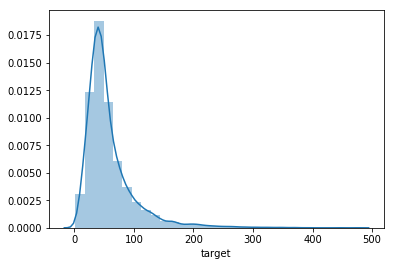

In [58]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(train['target'], bins=30)
plt.show()

target variable does not have normal distribution.
this can be normalised

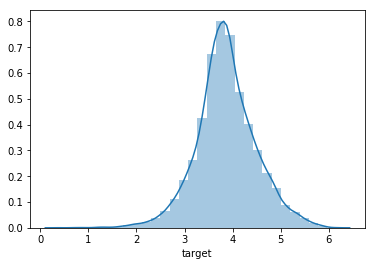

In [59]:
sns.distplot(np.log(train['target']), bins=30)
plt.show()

much better! something to keep in mind for later

#### Cross validation strategy (Kfold,or simple train test split )

In [18]:
Experiment_name="simple_model"

In [21]:
import os
os.makedirs("proc_data")
# os.makedirs("model_save/lgbm/{}".format(Experiment_name), exist_ok=True)
# os.makedirs("model_save/catboost/{}".format(Experiment_name), exist_ok=True)
# os.makedirs("model_save/xgboost/{}".format(Experiment_name), exist_ok=True)

In [22]:
try : 
    folds=pd.read_csv("./proc_data/folds_id.csv")
    train=train.merge(folds,on="ID",how="left")
    train.fold.nunique()
except : 
    #  you run this cell  only for the first time 
    from sklearn.model_selection import KFold 
    kfold=KFold(n_splits=5,shuffle=True,random_state=22) # change this random_state or all of you will have the same score  :D 
    train.reset_index(drop=True,inplace=True)
    folds=train[["ID"]].copy()
    folds["fold"]=0
    for fold,(tr_indx,val_ind) in enumerate(kfold.split(folds)) : 
        folds.loc[val_ind,"fold"]=fold
    folds.to_csv("./proc_data/folds_id.csv",index=False)
    train=train.merge(folds,on="ID",how="left")
    
    #del folds

In [25]:
folds.head()

ID  fold
0     ID_train_0     0
1     ID_train_1     2
2    ID_train_10     0
3   ID_train_100     4
4  ID_train_1000     1

In [32]:
train.head()

ID location      target   max_temp   min_temp  mean_temp  \
0     ID_train_0        C   45.126304  27.208333  19.275000  22.299527   
1     ID_train_1        D   79.131702  33.616667  17.983333  24.679063   
2    ID_train_10        A   32.661304  31.841667  18.458333  24.112317   
3   ID_train_100        A   53.850238  27.491667  16.941667  20.845273   
4  ID_train_1000        A  177.418750  28.750000  17.525000  21.870732   

   std_temp   var_temp  median_temp   ptp_temp  ...  newwind_dir119  \
0  2.594011   6.728895    21.358333   7.933333  ...             NaN   
1  4.266955  18.206903    23.791667  15.633333  ...       73.528733   
2  3.776377  14.261020    23.304167  13.383333  ...             NaN   
3  3.080140   9.487259    19.541667  10.550000  ...             NaN   
4  3.286870  10.803515    20.950000  11.225000  ...             NaN   

   windspeed119  atmospherepressure119  newtemp120  newprecip120  \
0           NaN                    NaN         NaN           NaN   
1      1.475833              90.439167   21.450000         0.561   
2           NaN              88.415833         NaN           NaN   
3           NaN              88.490833   24.641667         0.000   
4           NaN                    NaN         NaN           NaN   

   newrel_humidity120  newwind_dir120  windspeed120  atmospherepressure120  \
0                 NaN             NaN           NaN                    NaN   
1            0.797333      296.967254      1.019167              90.529167   
2                 NaN             NaN           NaN                    NaN   
3            0.719667             NaN           NaN              88.465833   
4                 NaN             NaN           NaN                    NaN   

   fold  
0     0  
1     2  
2     0  
3     4  
4     1  

[5 rows x 772 columns]

### Model 

### Lgbm 

In [33]:
train.columns

Index([u'ID', u'location', u'target', u'max_temp', u'min_temp', u'mean_temp',
       u'std_temp', u'var_temp', u'median_temp', u'ptp_temp',
       ...
       u'newwind_dir119', u'windspeed119', u'atmospherepressure119',
       u'newtemp120', u'newprecip120', u'newrel_humidity120',
       u'newwind_dir120', u'windspeed120', u'atmospherepressure120', u'fold'],
      dtype='object', length=772)

In [68]:
target_name="target"
id_name="ID"
features_to_remove=[target_name,id_name,"fold","location"]
features=train.columns.tolist()
features=[ fea for fea in  features if fea not in features_to_remove  ]


In [41]:
from sklearn.metrics import mean_squared_error
def metric(y,x):
    return np.sqrt(mean_squared_error(x,y))

In [45]:
import  lightgbm as lgbm 
import xgboost as xgb 
import catboost as cat 

In [49]:
def train_function(model,train,test,params,other_params,target_name,features,metric):
    folds_num=train.fold.nunique()
    validation=train[[id_name,"fold",target_name]].copy()
    validation["pred_"+target_name]=0
    sub=test[[id_name]].copy()
    sub[target_name]=0
    for fold in np.sort(train.fold.unique()):
        print("#"*50+" {} ".format(fold)+"#"*50)
        os.makedirs("model_save/lgbm/{}/{}".format(Experiment_name,str(int(fold))))
        X_train=train[train.fold!=fold]
        X_val=train[train.fold==fold]
        
        train_pred,validation_pred,test_pred=model(X_train,X_val,test,params,other_params)
        
        validation.loc[validation.fold==fold,"pred_"+target_name]=validation_pred
        sub[target_name]+=test_pred/folds_num
        train_score=metric(X_train[target_name],train_pred)
        val_score=metric(X_val[target_name],validation_pred)
        print("train score : {} validation score : {}".format(round(train_score,4),round(val_score,4)))
    final_validation_score=metric(validation[target_name],validation["pred_"+target_name])
    print("final validation score : {}".format(final_validation_score))
        
    return sub,validation,final_validation_score

def lgbm_model(X_train,X_val,X_test,params,other_params):
    dtrain = lgbm.Dataset(data=X_train[features], label=X_train[target_name], feature_name=features)
    dval = lgbm.Dataset(data=X_val[features], label=X_val[target_name], feature_name=features)

    model = lgbm.train(
        params=params,
        train_set=dtrain,
        num_boost_round=other_params["num_boost_round"],
        valid_sets=(dtrain, dval),
        early_stopping_rounds=other_params["early_stopping_rounds"],
        verbose_eval=other_params["verbose_eval"],
    )        
    best_iteration = model.best_iteration
    train_pred=model.predict(X_train[features], num_iteration=best_iteration)
    validation_pred=model.predict(X_val[features], num_iteration=best_iteration)
    test_pred=model.predict(test[features], num_iteration=best_iteration)
        
    return train_pred,validation_pred,test_pred

In [50]:
other_params={"num_boost_round":50000000,
              "early_stopping_rounds":50,
              "verbose_eval":1000,
}
lgbm_params = {
    "bagging_fraction": 0.8,
    "bagging_freq": 2,
    "boosting_type": "gbdt",
    "feature_fraction": 0.8,
    "learning_rate": 0.01,
    "max_depth": 8,
    "num_threads": 16,
    "objective": "regression",
    "metric": "rmse",
    "seed": 2020,
}

In [51]:
sub,validation,score=train_function(model=lgbm_model,
                                    train=train,
                                    test=test,
                                    params=lgbm_params,
                                    other_params=other_params,
                                    target_name=target_name,
                                    features=features,
                                    metric=metric)

################################################## 0 ##################################################
Training until validation scores don't improve for 50 rounds
[1000]	training's rmse: 17.8405	valid_1's rmse: 24.8516
[2000]	training's rmse: 13.5496	valid_1's rmse: 24.0602
[3000]	training's rmse: 11.2625	valid_1's rmse: 23.7802
Early stopping, best iteration is:
[3330]	training's rmse: 10.7261	valid_1's rmse: 23.7195
train score : 10.7261 validation score : 23.7195
################################################## 1 ##################################################
Training until validation scores don't improve for 50 rounds
[1000]	training's rmse: 17.6437	valid_1's rmse: 26.4439
[2000]	training's rmse: 13.4796	valid_1's rmse: 25.668
[3000]	training's rmse: 11.2088	valid_1's rmse: 25.3122
[4000]	training's rmse: 9.87054	valid_1's rmse: 25.1469
Early stopping, best iteration is:
[4166]	training's rmse: 9.70693	valid_1's rmse: 25.1269
train score : 9.7069 validation score : 25.1269


In [52]:
os.makedirs("subs")

In [53]:
sub.to_csv("./subs/lgbm_{}.csv".format(round(score,2)),index=False)

In [81]:
train.columns[0:10]

Index([u'ID', u'location', u'target', u'max_temp', u'min_temp', u'mean_temp',
       u'std_temp', u'var_temp', u'median_temp', u'ptp_temp'],
      dtype='object')

In [82]:
target_name="target"
id_name="ID"
features_to_remove=[target_name,id_name,"fold","location"]
features=train.columns.tolist()
features=[ fea for fea in  features if fea not in features_to_remove  ]

In [87]:
from sklearn.linear_model import Lasso, Ridge

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

In [92]:
train.isnull().sum().sum()

860681

In [93]:
from sklearn.impute import SimpleImputer

In [94]:
# cat_preprocessing = make_pipeline(
#     SimpleImputer(strategy='constant', fill_value='NA'),
#     OneHotEncoder(handle_unknown='ignore'))

# preprocess = make_column_transformer(
#     (cat_preprocessing, make_column_selector(dtype_include='object')),
#     remainder=cont_preprocessing)
# cont_preprocessing = make_pipeline(
#     SimpleImputer(),
#     StandardScaler())

X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target_name], random_state=0)

# cross_val_score(
#     make_pipeline(cont_preprocessing, Lasso()),
#     X_train, y_train, cv=5)

pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), Ridge())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)


0.2252061423815176

In [95]:
cross_val_score(
    pipe,
    X_train, y_train, cv=5)

array([0.25697464, 0.22472332, 0.22510738, 0.24776538, 0.22548098])